# Ex1: Onehot coding DNA

Write a function called **onehot_dna(dna_str)** that allows to encode a DNA segment where each base is encoded as a vector of all zeros except one in a specific position. The result of this function is an array numpy.  DNA is a long chain of repeating bases strung together. There are 4 bases: A, C, G, T. For example, "AACCCAAATCGGGGG" is a DNA segment.



For example, **onehot_dna('AAT')** should return

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])






In [1]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [2]:
def onehot_dna(dna_str):
    indexes = dict({"A": 0, "C": 1, "G": 2, "T": 3})
    res = []
    
    for letter in dna_str:
        code = [0] * 4
        code[indexes[letter]] = 1
        res.append(code)
    
    return np.array(res)


In [3]:
onehot_dna('AAT')

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

# Deep learning to classify Transcription Factor Biding


In the next exercises, we will learn how to use Deep learning to predict whether a segment of DNA does include or does not include a sit where JUND binds. (JUND is a particular transcription factor).

In this purpose, we will use data that is extracted from the chapter 6 of the book: 'Deep learning for the life science'. This book is written by B.Ramsundar, P.Eastman, P. Walters and V.Pande.



By looking at the Wikipedia page of the Jund transcription factor, explain what is the use of such protein 

JunD is a transcription factor encoded by the JUND gene, part of the AP-1 family. It regulates gene expression related to cell proliferation, differentiation, and apoptosis, playing a key role in maintaining cellular balance. JunD also protects against oxidative stress and has potential tumor-suppressing properties.


Data consist of DNA segments that have been split up from a full chromosome. Each segment is of 101 bases long and has been labeled to indicate whether it does or does not include a site where JUND binds to.


This is a binary classification problem.
The process of creating a PyTorch neural network binary classifier consists of several steps:

1. Prepare the training and test data

2. Implement a Dataset object to serve up the data

3. Design and implement a neural network

4. Write code to train the network

5. Write code to evaluate the model (the trained network)


# Ex 2:  Load Data

The data is available here : https://drive.google.com/drive/folders/1-nrTvNvEZo6Px1pnT7IeotKZR7p365UJ?usp=sharing

1. With the help of the joblib library, load the following files for training set:  **y_train.joblib**, **X_train.joblib**  and then store the results in variables **y_train, X_train** ,respectively.

2. Do the same thing for the test set: load  **y_test.joblib**, **X_test.joblib**  and then store the results in variables **y_test, X_test**, respectively.

3. What are the shape of **X_train** and **y_train** ? How many DNA segments are there in traning set ?

4. Display a DNA segment from **X_train** (using matplotlib.pyplot.imshow ).

5. Plot the histogram of **y_train** to see whether data is imbalanced or not.


In [4]:
X_train = joblib.load("data/X_train.joblib")
y_train = joblib.load("data/y_train.joblib")


In [5]:
''' Tests X_train, y_train '''
assert(X_train.shape == (4672, 101, 4))
assert(y_train.shape ==(4672, 1))



In [6]:
X_test = joblib.load("data/X_test.joblib")
y_test = joblib.load("data/y_test.joblib")


In [7]:
''' Tests X_test, y_test'''
assert(X_test.shape == (584, 101, 4))
assert(y_test.shape ==(584, 1))


#### Answer to question 3
X_train has a shape of (4672, 101, 4) while y_train has a shape of (4672, 1). There are 4672 DNA segments in the training set.

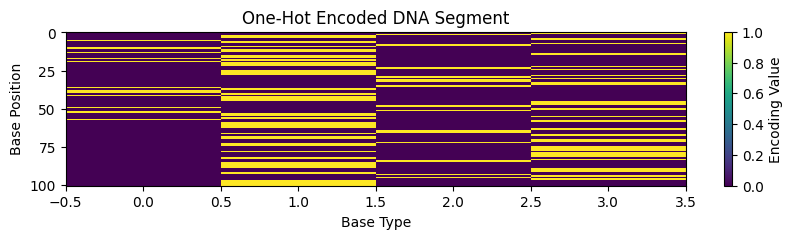

In [8]:
plt.figure(figsize=(10, 2))
plt.imshow(X_train[0], aspect='auto', interpolation='nearest')
plt.colorbar(label='Encoding Value')
plt.title('One-Hot Encoded DNA Segment')
plt.xlabel('Base Type')
plt.ylabel('Base Position')
plt.show()


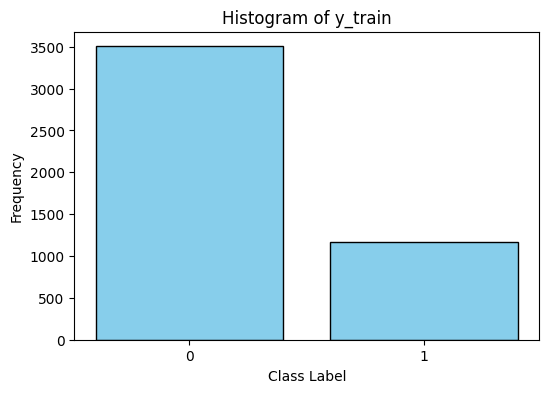

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(y_train, bins=2, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks([0.25, 0.75], ['0', '1'])
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Histogram of y_train')
plt.show()


We can observe a large imbalance between both classes. Indeed, there are almost 3 times more segments labelled as 0 than segments labelled as 1.

# Ex 3: Convert numpy array to tensor pytorch

As you see in the previous exercise, **X_train** consists of 4672 segments. Each segment is encoded by 0 and 1 (one-hot encoding).


1. Convert numpy array **X_train**, **y_train** into pytorch tensor. Reshape **X_train** to (4672, 4, 101). Note that the type of **X_train** and **y_train** should be float.

2. Do the same thing for **X_test** and **y_test**


In [10]:
X_train_ts = torch.from_numpy(X_train).to(torch.float32).permute((0, 2, 1))
y_train_ts = torch.from_numpy(y_train)
X_train_ts.shape

torch.Size([4672, 4, 101])

In [11]:
''' Tests X_train_ts, y_train_ts '''
assert(type(X_train_ts) is torch.Tensor)
assert(type(y_train_ts) is torch.Tensor)
assert(X_train_ts.shape == (4672, 4, 101))


In [12]:
X_test_ts = torch.from_numpy(X_test).to(torch.float32).permute((0, 2, 1))
y_test_ts = torch.from_numpy(y_test)
X_test_ts.shape

torch.Size([584, 4, 101])

In [13]:
''' Tests the above ToDo. '''
assert(type(X_test_ts) is torch.Tensor)
assert(type(y_test_ts) is torch.Tensor)
assert(X_test_ts.shape == (584, 4, 101))


# Ex4: Create Dataset
In order to train a deep learning model with Pytorch, we need a pytorch dataset.
The DNADataset class below allows for creating a pytorch Dataset from DNA segments and their labels.

1. Using this class, create a dataset for training set. You should call it **train_dataset**

2. Create **Dataloader** from **train_dataset**. You should call it **train_loader**.

3. Do the same thing for the test set.

In [14]:
class DNADataset(torch.utils.data.Dataset):
    def __init__(self, dna, labels):
        self.labels = labels
        self.dna = dna


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        label = self.labels[idx]
        frag_dna = self.dna[idx]

        sample = {'DNA': frag_dna, 'Class': label}

        return sample

In [15]:
train_dataset = DNADataset(X_train_ts, y_train_ts)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = DNADataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


**train_loader** is a generator. To get data out of it, you need to loop through it or convert it to an iterator and call next()

In [16]:
data = next(iter(train_loader))
dna = data['DNA']
label = data['Class']

print("a batch data ", dna.shape)
print("Shape of label", label.shape)

a batch data  torch.Size([64, 4, 101])
Shape of label torch.Size([64, 1])


# Design and implement a convolutional neural network

Now, it's time to build your model. This is a binary classification problem. We can use a convolution neural network, just like an image classification problem. However, since the size of a DNA segment is (4, 101), we will use 1D convolution instead of 2D convolution.



Firstly, we will test how does a 1D convolution work on our data.



# EX 5: 1D Convolution

1. With the help of the torch.nn.Conv1d class, create a 1D convolutional layer. You need to choose values for the following parameters: **in_channels**, **out_channels**, **kernel_size**.


2. Apply this layer to **dna_seg** below. What is the size of the output ?


3. [Optional] Display the output by using matplotlib.pyplot.imshow




In [17]:
data = next(iter(train_loader))
dna_seg = data['DNA']
y = data['Class']


In [18]:
in_channels = 4
out_channels = 8
kernel_size = 5

conv1d_layer = nn.Conv1d(in_channels, out_channels, kernel_size)
output = conv1d_layer(dna_seg)
output_shape = output.shape

output_shape

torch.Size([64, 8, 97])

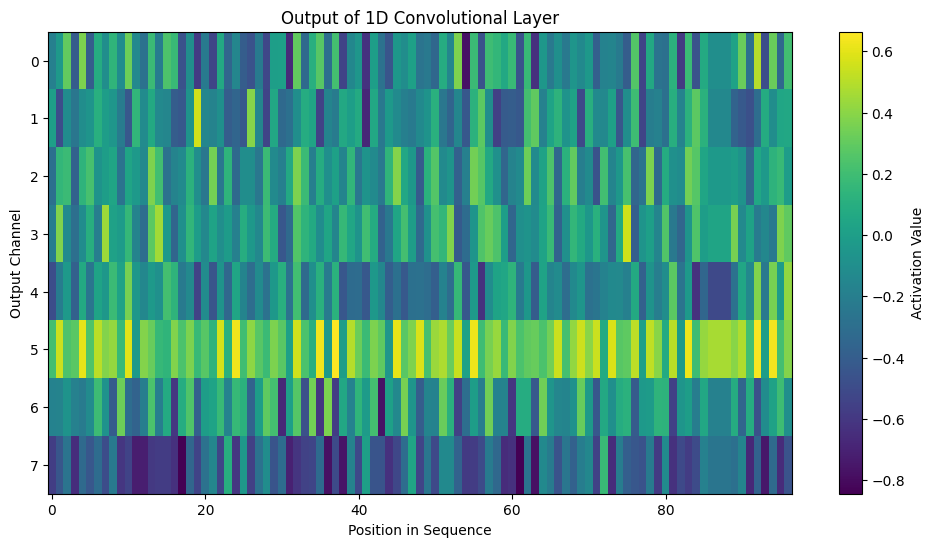

In [19]:
output_np = output.detach().numpy()[0]

plt.figure(figsize=(12, 6))
plt.imshow(output_np, aspect='auto', cmap='viridis')
plt.colorbar(label='Activation Value')
plt.title('Output of 1D Convolutional Layer')
plt.xlabel('Position in Sequence')
plt.ylabel('Output Channel')
plt.show()

# EX 6: Build a model

Create a 3 layer 1-dimensional network to classify the TF binding sites

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class DeepDNA(nn.Module):
  def __init__(self, input_length):
    super(DeepDNA, self).__init__()

    self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
    self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

    output_length = input_length // 8
    self.fc = nn.Linear(64 * output_length, 1)
    
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))

    x = x.view(x.size(0), -1)

    x = torch.sigmoid(self.fc(x))

    return x



# Ex 7 Test the model


1. Create an instance of the DeepDNA class named **net**.

2. Print out the variable **net** to see detailed information about the model.

3. Pass **dna_seg** below to **net** in order to  test if your model **net** works well.

4. What is the size of the output ?



In [21]:
dna_seg = data['DNA']

net = DeepDNA(101)
out = net(dna_seg)

print("the output of the model ", out[:5])



the output of the model  tensor([[0.5122],
        [0.5144],
        [0.5195],
        [0.5157],
        [0.5183]], grad_fn=<SliceBackward0>)


In [22]:
print(net)

DeepDNA(
  (conv1): Conv1d(4, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=768, out_features=1, bias=True)
)


In [23]:
print(out.shape)

torch.Size([64, 1])


The output has a shape of (64, 1). Hence, it has a length of 64 values.

# Ex 8: Define loss function and optimizer


1. Define an SGD optimizer for the model. You need to choose the learning rate for your model.

2. Define a Binary Cross Entropy (BCE) Loss  function.


In [24]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.001)


# Ex 9: Training your model

The following function allows to train the model for one epoch. This function returns total loss per epoch.
Implement the training pass for this function.



The general process with PyTorch for one learning step consits of several steps:

1. Make a forward pass through the network
2. Use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights



In [25]:
def train():
    net.train()
    loss_epoch = 0
    batch_count = 0

    for batch_data in train_loader:
        inputs = batch_data['DNA'].float()
        labels = batch_data['Class']

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels.to(torch.float32))

        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        batch_count += 1
       

    return loss_epoch / batch_count

# Ex 11: Accuracy Calculation

Write a function named **compute_num_correct_pred(y_prob, y_label)** that allows to compute the number of correct predictions. **y_prob** and **y_label** should be pytorch tensors.

For example,
y_prob = [[0.3],[0.4], [0.8], [0.7]].

y = [[0], [1], [1], [0]].

This function should return 2.

In [26]:
def compute_num_correct_pred(y_prob, y_label):
    res = 0
    y_p = y_prob.round().to(torch.int)
    
    for v1, v2 in zip(y_label, y_p):
        if v1 == v2:
            res += 1
    
    return res


In [27]:
compute_num_correct_pred(torch.tensor([[0.3], [0.4], [0.8], [0.7]]), torch.tensor([[0], [1], [1], [0]]))


2


The function below allows to calculate the accuracy of the model on dataset loader. Execute this function to see if you implemented the compute_num_correct_pred function correctly.

In [28]:
def test(loader):
  net.eval()

  correct = 0
  with torch.no_grad():
    for data in loader:
      dna = data['DNA'].float()
      y = data['Class']
      
      dna = dna.permute((0, 2, 1))
      out = net(dna)

      correct += compute_num_correct_pred(out, y)

  return correct / len(loader.dataset)

# Ex 12: Training the model

The code below allows to train your model on 10 epoches. If all work well, you should see the training loss drop with each epoch.

train the model for 2000 epochs

In [29]:
num_epochs = 2000
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = train()
    test_accuracy = test(test_loader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}")

    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)

print("Training complete.")


Epoch [10/2000], Train Loss: 0.5702
Epoch [20/2000], Train Loss: 0.5628
Epoch [30/2000], Train Loss: 0.5628
Epoch [40/2000], Train Loss: 0.5627
Epoch [50/2000], Train Loss: 0.5626
Epoch [60/2000], Train Loss: 0.5626
Epoch [70/2000], Train Loss: 0.5625
Epoch [80/2000], Train Loss: 0.5625
Epoch [90/2000], Train Loss: 0.5624
Epoch [100/2000], Train Loss: 0.5623
Epoch [110/2000], Train Loss: 0.5623
Epoch [120/2000], Train Loss: 0.5622
Epoch [130/2000], Train Loss: 0.5622
Epoch [140/2000], Train Loss: 0.5621
Epoch [150/2000], Train Loss: 0.5621
Epoch [160/2000], Train Loss: 0.5620
Epoch [170/2000], Train Loss: 0.5620
Epoch [180/2000], Train Loss: 0.5619
Epoch [190/2000], Train Loss: 0.5619
Epoch [200/2000], Train Loss: 0.5618
Epoch [210/2000], Train Loss: 0.5618
Epoch [220/2000], Train Loss: 0.5617
Epoch [230/2000], Train Loss: 0.5617
Epoch [240/2000], Train Loss: 0.5616
Epoch [250/2000], Train Loss: 0.5616
Epoch [260/2000], Train Loss: 0.5615
Epoch [270/2000], Train Loss: 0.5615
Epoch [280

# Ex13 (optional)



1. If we use torch.nn.BCEWithLogitsLoss(), what does we need to change to the definition of the model ?



2. The same question for torch.nn.CrossEntropyLoss() loss.  

1. BCEWithLogitsLoss combines a sigmoid activation with binary cross-entropy loss. This means that if we use this loss function, we don't need to apply the sigmoid activation manually in the model. We can then remove it from the forward function of our model

2. CrossEntropyLoss is used for multi-class classification. It expects the model output to be raw logits for each class, and the target labels should be integers representing class indices. Hence, we will need to change the output layer of the model to predict multiple classes (in our case, we will need 2 outputs instead of 1 since it is a binary classification task).